In [ ]:
# default_exp core

In [ ]:
%load_ext autoreload
%autoreload 2

# MS Peptide Stability

> Compute peptide Tm from MS peptide stability data. Useful for pMHC analysis. 

In [ ]:
# hide
from nbdev.showdoc import *
from matplotlib import pyplot as plt
import pandas as pd
import scipy as sp
import numpy as np
from scipy.optimize import curve_fit
import os
from scipy.special import expit

In [ ]:
# Decaying sigmoid
def sigmoid(x, x0, k):
    y = expit(-k*(x-x0))
    return y

In [ ]:
# Load experimental parameters
def load_params(data_dir, peptide_file, tmt_file):
    peptides = pd.read_csv(peptide_file, index_col=0, sep=' ')
    tmt_params = pd.read_csv(tmt_file, sep=' ')
    # Add a column referencing tmt_total in the PSM export
    tmt_params['tmt_total'] = tmt_params['TMT'] + '_total'
    return (peptides, tmt_params)


# Example
data_dir = '~/Documents/Hacohen/Data/2021/6-22-21/'
peptide_file = os.path.join(data_dir, 'peptides.csv')  # Peptides for analysis
tmt_file = os.path.join(data_dir, 'tmt_map.csv')
peptide_lst, tmt_params = load_params(data_dir, peptide_file, tmt_file)
tmt_params

,temp,TMT,tmt_total
0,37,TMT_129,TMT_129_total
1,46,TMT_128,TMT_128_total
2,53,TMT_130,TMT_130_total
3,62,TMT_126,TMT_126_total
4,70,TMT_131,TMT_131_total


In [ ]:
# Load PSM data and compute normalization

def compute_iRT_norm(ms_data):
    # Calculate normalization for TMT data from IRT peptides
    iRT_data = ms_data[ms_data['species'] == 'Biognosys-iRT']
    iRT_tmt = iRT_data[tmt_params['tmt_total'].values]
    iRT_tmt_log_mean = iRT_tmt.apply(np.log10).mean()
    iRT_tmt_norm = iRT_tmt_log_mean/iRT_tmt_log_mean[0]
    return iRT_tmt_norm


psm_file = 'peptideExport.CS.3.csv'
ms_data = pd.read_csv(os.path.join(data_dir, psm_file), sep=';')
ms_peptide_data = ms_data[ms_data['sequence'].isin(
    peptide_lst['seq'])]  # Select peptides from peptide list
iRT_norm_factor = compute_iRT_norm(ms_data)
iRT_norm_factor

TMT_129_total    1.000000
TMT_128_total    1.007698
TMT_130_total    0.998536
TMT_126_total    1.002806
TMT_131_total    0.987047
dtype: float64

In [ ]:
# Normalize peptide data
peptide_tmt = ms_peptide_data[tmt_params['tmt_total'].values]
peptide_tmt_norm = peptide_tmt/iRT_norm_factor
peptide_tmt_norm.head()

,TMT_129_total,TMT_128_total,TMT_130_total,TMT_126_total,TMT_131_total
151,5.658345e+09,4.188397e+09,1.828361e+09,1.453866e+07,2.686582e+06


## Analyze individual peptides
> Plot stability results for a single peptide

Tm = 50.072313311538615


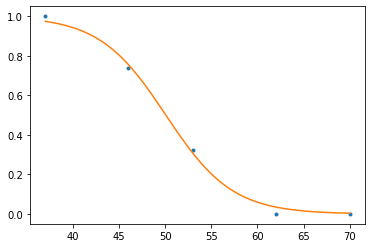

In [ ]:
# Plot normalized TMT for a peptide of interest
def compute_stability(x, y):
    # Fit a sigmoid to the data (normalized to 1 to match the function)
    p0 = [np.mean(x), 1.0]  # Initial guess for Tm, offset
    popt, pcov = curve_fit(sigmoid, x, y, p0)
    return popt, pcov


def plot_stability(x, y, popt):
    x_fit = np.linspace(x[0], x[-1], 50)  # Draw model fit
    y_fit = sigmoid(x_fit, *popt)
    # Plot data and fit
    plt.plot(x, y, '.')
    plt.plot(x_fit, y_fit)


sequence = 'SIINFEKL'
pidx = ms_peptide_data[ms_peptide_data['sequence'] == sequence].index
assert len(pidx) == 1  # Make sure this maps to only one peptide
tmt_values = peptide_tmt_norm.loc[pidx[0]]
tmt_values = (tmt_values/tmt_values[0]).values  # Scale values to 0-1
temps = tmt_params['temp'].values

popt, pcov = compute_stability(temps, tmt_values)
plot_stability(temps, tmt_values, popt)
print("Tm = {}".format(popt[0]))

In [ ]:
from nbdev.export import notebook2script; notebook2script()

Converted 00_core.ipynb.
Converted index.ipynb.
